In [1]:
from pytorch_grad_cam import LayerCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import torch
from loader import ImagesDataset
from evaluate import img_pipe
from matplotlib import pyplot as plt
import numpy as np
from model import cls
from torch.utils.data import Dataset
from evaluate import img_pipe
import numpy as np

/home/rockyo/anaconda3/envs/test/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'T1 HB': [[0.2962, 0.2962, 0.2962], [0.2527, 0.2527, 0.2527]], 'T2': [[0.2055, 0.2055, 0.2055], [0.1727, 0.1727, 0.1727]], 'out': [[0.2, 0.2, 0.2], [0.1644, 0.1644, 0.1644]]}
Loaded pretrained weights for efficientnet-b2


In [2]:
class ds(Dataset):
    def __init__(self, df, mode):
        super().__init__()

        imgs = {
            'T1 HB': [], 
            'T2'   : [], 
            'out'  : [],
        }

        for row in df.iterrows():
            f=row[1]['filename'].replace('dy','rockyo').replace('chime-pj', 'liver-canser-prediction')
            for mri_type in imgs.keys():
                fname = f.replace('mri_type', mri_type)+'.jpg'
                img = img_pipe(fname, mri_type, mode=mode)
                imgs[mri_type].append(img)

        img_tensor={}
        for k in imgs.keys():
            img_tensor[k] = torch.stack(imgs[k])
        self.imgs = img_tensor
        self.label = torch.tensor(df['class_one_hot'].values.tolist())
        self.class_weight  = np.unique(df['class_one_hot'].values.tolist(), return_counts=True)[1]
        print(self.class_weight)
        self.class_weight = 1 / (self.class_weight / df.shape[0]*2)
        
    def __len__(self):
        return len(self.imgs['T2'])

    def __getitem__(self, idx):
        item = {
            **{ k.replace(' ', '_'):v[idx] for k, v in self.imgs.items()},
            'label': self.label[idx],   
        }
        return item

In [6]:
ds = ImagesDataset()
target_category = 1
#! select ur source mri image
f = '/home/rockyo/byol/data/segmented_liver/pT2 HCC/mri_type/26180159'

138 images found


In [7]:
from torchvision import transforms as T
from evaluate import ImgPad
from PIL import Image
def img_process(f):
    image_size = 200
    preprocess = T.Compose([     
        T.ToTensor(),
        ImgPad(image_size),  
        T.Resize((image_size, image_size)),
    ])
    img = Image.open(f +'.jpg')
    img = preprocess(img).numpy()
    img = np.moveaxis(img, 0, -1)
    return img
def show_cam(f, model_cam, target_layer):
    cam = LayerCAM(model=model_cam, target_layer=target_layer, use_cuda=True)
    img1 = img_pipe(f.replace('mri_type', 'out') + '.jpg', 'out', mode="eval")
    img2 = img_pipe(f.replace('mri_type', 'T2') + '.jpg', 'T2', mode="eval")
    img3 = img_pipe(f.replace('mri_type', 'T1 HB') + '.jpg', 'T1 HB', mode="eval")
    imgs = torch.stack(
        [
         img2,
        ]
    )
    grayscale_cam = cam(input_tensor=imgs
                        ,
        eigen_smooth=True
    )
    return grayscale_cam

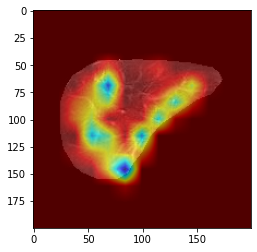

In [8]:
m = cls(class_weight=[0.78409091, 1.38], enc='ca', load_pretrained=False)

model_path = '/home/rockyo/byol/model/model_ca/0.85_0.78.pth'

m.load_state_dict(torch.load(model_path))
model_cam = m.encoder.netwrapper.net.net
target_layer = model_cam._blocks[11]

g = show_cam(f, model_cam, target_layer)
for i, t in enumerate(['T2',]):
    img = img_process(f.replace('mri_type', t))
    v = show_cam_on_image(img, g[i])
    plt.imshow(v)
    plt.show()